In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import itertools

import matplotlib
matplotlib.rcParams.update({'font.size': 17.5})

import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('axes.formatter', useoffset=False)


import sys
import os.path
sys.path.append( os.path.abspath(os.path.join( os.path.dirname('..') , os.path.pardir )) )

In [11]:
from collapsingFLAMEbit import *
from genericFLAMEbit import *

In [12]:
def construct_sec_order(arr):
    ''' an intermediate data generation function used 
        for generating second order information '''
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)

In [13]:
def data_generation_hybrid(num_control, num_treated, num_cov, exponential = True):
    
    # a data generation function, not used here
    
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov))   # data for conum_treatedrol group
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov))   # data for treatmenum_treated group
        
    errors1 = np.random.normal(0, 0.05, size=num_control)    # some noise
    errors2 = np.random.normal(0, 0.05, size=num_treated)    # some noise
    
    #dense_bs_sign = np.random.choice([-1,1], num_cov_dense)
    if exponential:
        dense_bs = [ 20.*((4./5)**(i+1)) for i in range(num_cov) ]
    else:
        dense_bs = [ (20./(i+1)) for i in range(num_cov) ]

    yc = np.dot(xc, np.array(dense_bs)) #+ errors1     # y for control group 

    # y for treated group 
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov) #beta
    treatment_effect = np.dot(xt, treatment_eff_coef) 
    
    yt = np.dot(xt,np.array(dense_bs))+treatment_effect 
                                      # + errors2    
        
    df1 = pd.DataFrame(np.hstack([xc]), 
                       columns=range(num_cov))
    df1['outcome'] = yc
    df1['treated'] = 0

    df2 = pd.DataFrame(np.hstack([xt]), 
                       columns=range(num_cov ) ) 
    df2['outcome'] = yt
    df2['treated'] = 1

    df = pd.concat([df1,df2])
    df['matched'] = 0
  
    return df, dense_bs, treatment_eff_coef

In [14]:
#------- EXPERIMENT 1: N=11K, P=10 -----------------------------#

In [15]:
# data generation, set exponential to be True or False for exponential decay and power-law decay respectively

d = data_generation_hybrid(15000, 15000, 18, exponential=True)
df = d[0] 
holdout,_,_ = data_generation_hybrid(15000, 15000, 18, exponential=True)


In [16]:
#run generic FLAME
res_gen = run_bit(df, holdout, range(18), [2]*18, threshold = 20385, tradeoff_param = 0.001)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17]
reached threshold


In [17]:
#run Collapsing FLAME
res = run_mpbit(df, holdout, range(18), [2]*18, threshold =20385, tradeoff_param = 0.001)

reached threshold


In [17]:
#pickle.dump(d, open('412data', 'wb'))
# save dataframe used for comparing with other methods (PSNNM, Mahalanobis, Causal Forest)
d[0].to_csv('412dataframe.csv')

In [18]:
def ground_truth( eff_coef, covs_ordered, num_covs_dense = 18, num_second_order = 0, second_order = True):
    arr = np.array(list(itertools.product([0,1], repeat=num_covs_dense)))
    effect = np.dot(arr, eff_coef)
    if second_order:
        second_effect = np.sum(construct_sec_order(arr[:,:num_second_order] ), axis=1)
        effect = effect + second_effect
    df = pd.DataFrame(arr, columns=covs_ordered)
    df['effect'] = effect
    return df



In [19]:
#create ground truth
ground_truth = ground_truth(d[2], list(range(18)), num_covs_dense = 18, num_second_order = 0, second_order = False)



In [21]:
ground_truth.to_csv('412groundtruth.csv')

In [20]:
# generate the lists of true and estimated cates for collapsing FLAME

truth_list = []
pred_list = []
count = 0
av_err_cate = []
aux_size = []
for r in res[1]:
    count = count +1
    tmp = pd.merge(r, ground_truth, on = list(set(range(18)) & set(r.columns) ), how = 'left')
    truth_list = truth_list + list(tmp['effect_y'])
    pred_list = pred_list + list(tmp['effect_x'])
    aux_size = aux_size + list(tmp['size'])



In [21]:
# generate the lists of true and estimated cates for generic FLAME

truth_list_gen = []
pred_list_gen = []

aux_size_gen = []
av_err_cate_gen = []
for r_gen in res_gen[1]:
    tmp_gen = pd.merge(r_gen, ground_truth, on = list(set(range(18)) & set(r_gen.columns) ), how = 'left')
    truth_list_gen = truth_list_gen + list(tmp_gen['effect_y'])
    pred_list_gen = pred_list_gen + list(tmp_gen['effect_x'])
    aux_size_gen = aux_size_gen + list(tmp_gen['size'])



In [22]:
# create a dataframe with the true and estimated cates : 


effect_col = pd.DataFrame()
effect_col['pred'] = pred_list
effect_col['true'] = truth_list
effect_col['size'] = aux_size

effect_col['method'] = ['collapsing FLAME']*len(truth_list)

effect_gen = pd.DataFrame()
effect_gen['pred'] = pred_list_gen
effect_gen['true'] = truth_list_gen
effect_gen['method'] = ['generic FLAME']*len(truth_list_gen)
effect_gen['size'] = aux_size_gen


effect = pd.concat([effect_gen, effect_col])


effect_col.to_csv('effect412col_th1.csv')

effect_gen.to_csv('effect412gen_th1.csv')

effect.to_csv('effect412_th1.csv')


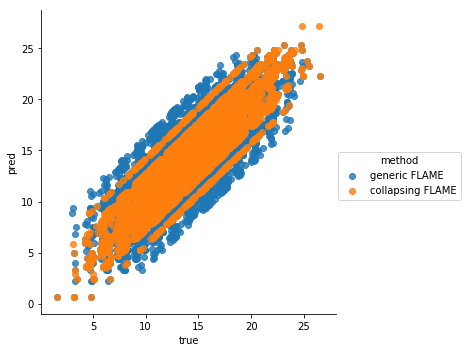

In [46]:
#-----PLOT FOR THRESHOLD 1----------#

import seaborn as sns
sns.lmplot(x="true", y="pred",hue="method", data = effect, fit_reg=False)


In [47]:
#------- THRESHOLD2 -----------------------------#

In [48]:
res_gen1 = run_bit(df, holdout, range(18), [2]*18, threshold =15070, tradeoff_param = 0.001)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
reached threshold


In [49]:
res1 = run_mpbit(df, holdout, range(18), [2]*18, threshold = 15070, tradeoff_param = 0.001)

reached threshold


In [50]:
truth_list1 = []
pred_list1 = []
count = 0
av_err_cate = []
aux_size1 = []
for r in res1[1]:
    count = count +1
    tmp1 = pd.merge(r, ground_truth, on = list(set(range(18)) & set(r.columns) ), how = 'left')
    truth_list1 = truth_list1 + list(tmp1['effect_y'])
    pred_list1 = pred_list1 + list(tmp1['effect_x'])
    aux_size1 = aux_size1 + list(tmp1['size'])


truth_list_gen1 = []
pred_list_gen1 = []

aux_size_gen1 = []
av_err_cate_gen1 = []
for r_gen in res_gen1[1]:
    tmp_gen1 = pd.merge(r_gen, ground_truth, on = list(set(range(18)) & set(r_gen.columns) ), how = 'left')
    truth_list_gen1 = truth_list_gen1 + list(tmp_gen1['effect_y'])
    pred_list_gen1 = pred_list_gen1 + list(tmp_gen1['effect_x'])
    aux_size_gen1 = aux_size_gen1 + list(tmp_gen1['size'])




In [51]:
# create a dataframe with the true and estimated cates : 

effect_col1 = pd.DataFrame()
effect_col1['pred'] = pred_list1
effect_col1['true'] = truth_list1
effect_col1['size'] = aux_size1

effect_col1['method'] = ['collapsing FLAME']*len(truth_list1)

effect_gen1 = pd.DataFrame()
effect_gen1['pred'] = pred_list_gen1
effect_gen1['true'] = truth_list_gen1
effect_gen1['method'] = ['generic FLAME']*len(truth_list_gen1)
effect_gen1['size'] = aux_size_gen1


effect1 = pd.concat([effect_gen1, effect_col1])


effect_col1.to_csv('effect412col_th2.csv')

effect_gen1.to_csv('effect412gen_th2.csv')

effect1.to_csv('effect412_th2.csv')

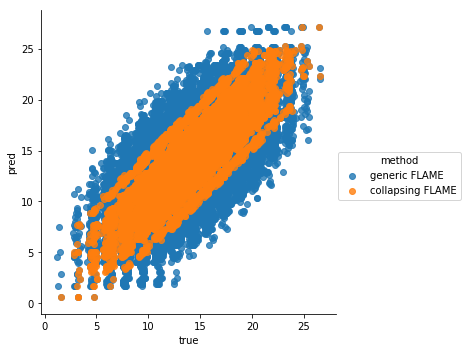

In [52]:
import seaborn as sns
sns.lmplot(x="true", y="pred",hue="method", data = effect1, fit_reg=False)


In [ ]:
#------- THRESHOLD3-----------------------------#

In [53]:
res_gen2 = run_bit(df, holdout, range(18), [2]*18, threshold =10459, tradeoff_param = 0.001)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
reached threshold


In [54]:

res2 = run_mpbit(df, holdout, range(18), [2]*18, threshold = 10459, tradeoff_param = 0.001)


reached threshold


In [55]:
truth_list2 = []
pred_list2 = []
count = 0
av_err_cate = []
aux_size2 = []
for r in res2[1]:
    count = count +1
    tmp2 = pd.merge(r, ground_truth, on = list(set(range(18)) & set(r.columns) ), how = 'left')
    truth_list2 = truth_list2 + list(tmp2['effect_y'])
    pred_list2 = pred_list2 + list(tmp2['effect_x'])
    aux_size2 = aux_size2 + list(tmp2['size'])


truth_list_gen2 = []
pred_list_gen2 = []

aux_size_gen2 = []
for r_gen in res_gen2[1]:
    tmp_gen2 = pd.merge(r_gen, ground_truth, on = list(set(range(18)) & set(r_gen.columns) ), how = 'left')
    truth_list_gen2 = truth_list_gen2 + list(tmp_gen2['effect_y'])
    pred_list_gen2 = pred_list_gen2 + list(tmp_gen2['effect_x'])
    aux_size_gen2 = aux_size_gen2 + list(tmp_gen2['size'])


In [56]:

# create a dataframe with the true and estimated cates : 

effect_col2 = pd.DataFrame()
effect_col2['pred'] = pred_list2
effect_col2['true'] = truth_list2
effect_col2['size'] = aux_size2

effect_col2['method'] = ['collapsing FLAME']*len(truth_list2)


#effect_col.to_csv('effect.csv')

effect_gen2 = pd.DataFrame()
effect_gen2['pred'] = pred_list_gen2
effect_gen2['true'] = truth_list_gen2
effect_gen2['method'] = ['generic FLAME']*len(truth_list_gen2)
effect_gen2['size'] = aux_size_gen2


effect2 = pd.concat([effect_gen2, effect_col2])


effect_col2.to_csv('effect412col_th3.csv')

effect_gen2.to_csv('effect412gen_th3.csv')

effect2.to_csv('effect412_th3.csv')

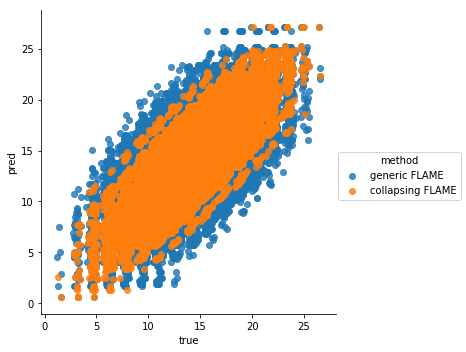

In [57]:
import seaborn as sns
sns.lmplot(x="true", y="pred",hue="method", data = effect2, fit_reg=False)
